<a id="title"></a>
# WFC3/UVIS Filter Transformations with stsynphot 
***
## Learning Goals

By the end of this tutorial, you will:
- Generate synthetic observations using `synphot` and `stsynphot`.
- Find color terms between WFC3/UVIS filters and non-HST filters.
- Plot bandpasses to investigate various throughputs.


## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Select filters for the transformation](#select) <br>
[3. Define a spectrum](#spec) <br>
[4. Select UVIS chips](#chips) <br>
[5. Select magnitude systems](#system) <br>
[6. Generate outputs](#output) <br>
[7. Plot bandpasses](#band) <br>
[8. Conclusions](#conclusion) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction
This notebook computes color terms between selected WFC3/UVIS filters and non-HST filters, such as Johnson-Cousins, for a user-defined reference spectrum. The terms as given are the difference between the magnitude of the spectrum in the selected non-HST filter and the corresponding UVIS filter. 

This tool reproduces the methods described in section 4 of [WFC3 ISR 2014-16](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2014/WFC3-2014-16.pdf), but will automatically use the latest available spectra and throughput tables.

`stsynphot` requires access to data distributed by the [Calibration Data Reference System](https://hst-crds.stsci.edu/) (CRDS) in order to operate. Both packages look for an environment variable called `PYSYN_CDBS` to find the directory containing these data.

Users can obtain these data files from the CDRS. Information on how to obtain the most up-to-date reference files (and what they contain) can be found [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/synphot-throughput-tables). An example of how to download the files with `curl` and set up this environment variable is presented below.

For detailed instructions on how to install and set up these packages, see the [synphot](https://synphot.readthedocs.io/en/latest/#installation-and-setup) and [stsynphot](https://stsynphot.readthedocs.io/en/latest/#installation-and-setup) documentation.

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 notebooks'](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/README.md) installation instructions.

We import:

- *os* for setting environment variables
- *tarfile* for extracting a .tar archive
- *numpy* for handling array functions
- *pandas* for managing data
- *matplotlib.pyplot* for plotting data
- *astropy.units* and *synphot.units* for handling units
- *synphot* and *stsynphot* for evaluating synthetic photometry

Additionally, we will need to set the `PYSYN_CDBS` environment variable *before* importing stsynphot. We will also create a Vega spectrum using synphot's inbuilt `from_vega()` method, as the latter package will supercede this method's functionality and require a downloaded copy of the latest Vega spectrum to be provided.

In [1]:
import os
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import synphot.units as su
import synphot as syn
from synphot import Observation

%matplotlib inline

vegaspec = syn.SourceSpectrum.from_vega()

This section obtains the WFC3 throughput component tables for use with `stsynphot`. This step only needs to be done once. If these reference files have already been downloaded, this section can be skipped.

In [2]:
!curl -O https://archive.stsci.edu/hlsps/reference-atlases/hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  796M    0 6064k    0     0  5356k      0  0:02:32  0:00:01  0:02:31 5352k

  4  796M    4 37.8M    0     0  17.9M      0  0:00:44  0:00:02  0:00:42 17.8M

  8  796M    8 65.2M    0     0  20.8M      0  0:00:38  0:00:03  0:00:35 20.8M

 10  796M   10 82.4M    0     0  19.8M      0  0:00:40  0:00:04  0:00:36 19.8M

 12  796M   12 98.2M    0     0  19.2M      0  0:00:41  0:00:05  0:00:36 19.7M

 13  796M   13  110M    0     0  18.1M      0  0:00:43  0:00:06  0:00:37 21.0M

 14  796M   14  119M    0     0  16.6M      0  0:00:47  0:00:07  0:00:40 16.1M

 15  796M   15  125M    0     0  15.4M      0  0:00:51  0:00:08  0:00:43 12.0M

 16  796M   16  130M    0     0  14.2M      0  0:00:55  0:00:09  0:00:46 9841k

 17  796M   17  136M    0     0  13.4M      0  0:00:59  0:00:10  0:00:49 7707k

 17  796M   17  142M    0     0  12.7M      0  0:01:02  0:00:11  0:00:51 6299k

 18  796M   18  147M    0     0  12.1M      0  0:01:05  0:00:12  0:00:53 5899k

 19  796M   19  153M    0     0  11.7M      0  0:01:08  0:00:13  0:00:55 5808k

 19  796M   19  159M    0     0  11.2M      0  0:01:10  0:00:14  0:00:56 5858k

 20  796M   20  163M    0     0  10.8M      0  0:01:13  0:00:15  0:00:58 5728k

 21  796M   21  168M    0     0  10.4M      0  0:01:15  0:00:16  0:00:59 5557k

 21  796M   21  174M    0     0  10.1M      0  0:01:18  0:00:17  0:01:01 5492k

 22  796M   22  180M    0     0   9.9M      0  0:01:20  0:00:18  0:01:02 5497k

 23  796M   23  186M    0     0  9974k      0  0:01:21  0:00:19  0:01:02 5592k

 24  796M   24  192M    0     0  9774k      0  0:01:23  0:00:20  0:01:03 5774k

 24  796M   24  198M    0     0  9602k      0  0:01:24  0:00:21  0:01:03 5980k

 25  796M   25  204M    0     0  9454k      0  0:01:26  0:00:22  0:01:04 6074k

 26  796M   26  210M    0     0  9294k      0  0:01:27  0:00:23  0:01:04 6049k

 27  796M   27  216M    0     0  9186k      0  0:01:28  0:00:24  0:01:04 6176k

 27  796M   27  221M    0     0  9046k      0  0:01:30  0:00:25  0:01:05 6103k

 28  796M   28  227M    0     0  8897k      0  0:01:31  0:00:26  0:01:05 5916k

 29  796M   29  231M    0     0  8735k      0  0:01:33  0:00:27  0:01:06 5562k

 29  796M   29  235M    0     0  8578k      0  0:01:35  0:00:28  0:01:07 5249k

 30  796M   30  238M    0     0  8402k      0  0:01:37  0:00:29  0:01:08 4615k

 30  796M   30  242M    0     0  8243k      0  0:01:38  0:00:30  0:01:08 4221k

 30  796M   30  245M    0     0  8057k      0  0:01:41  0:00:31  0:01:10 3677k

 30  796M   30  246M    0     0  7852k      0  0:01:43  0:00:32  0:01:11 3068k

 31  796M   31  247M    0     0  7652k      0  0:01:46  0:00:33  0:01:13 2455k

 31  796M   31  248M    0     0  7455k      0  0:01:49  0:00:34  0:01:15 1977k

 31  796M   31  249M    0     0  7272k      0  0:01:52  0:00:35  0:01:17 1420k

 31  796M   31  250M    0     0  7089k      0  0:01:55  0:00:36  0:01:19 1034k

 31  796M   31  250M    0     0  6916k      0  0:01:57  0:00:37  0:01:20  930k

 31  796M   31  251M    0     0  6764k      0  0:02:00  0:00:38  0:01:22  880k

 31  796M   31  252M    0     0  6619k      0  0:02:03  0:00:39  0:01:24  878k

 31  796M   31  254M    0     0  6482k      0  0:02:05  0:00:40  0:01:25  942k

 32  796M   32  255M    0     0  6355k      0  0:02:08  0:00:41  0:01:27 1082k

 32  796M   32  256M    0     0  6245k      0  0:02:10  0:00:42  0:01:28 1227k

 32  796M   32  258M    0     0  6142k      0  0:02:12  0:00:43  0:01:29 1385k

 32  796M   32  261M    0     0  6058k      0  0:02:14  0:00:44  0:01:30 1676k

 33  796M   33  263M    0     0  5975k      0  0:02:16  0:00:45  0:01:31 1911k

 33  796M   33  266M    0     0  5907k      0  0:02:18  0:00:46  0:01:32 2188k

 33  796M   33  268M    0     0  5843k      0  0:02:19  0:00:47  0:01:32 2467k

 34  796M   34  271M    0     0  5784k      0  0:02:20  0:00:48  0:01:32 2709k

 34  796M   34  274M    0     0  5728k      0  0:02:22  0:00:49  0:01:33 2827k

 34  796M   34  277M    0     0  5674k      0  0:02:23  0:00:50  0:01:33 2962k

 35  796M   35  280M    0     0  5626k      0  0:02:24  0:00:51  0:01:33 3038k

 35  796M   35  283M    0     0  5579k      0  0:02:26  0:00:52  0:01:34 3076k

 36  796M   36  287M    0     0  5536k      0  0:02:27  0:00:53  0:01:34 3153k

 36  796M   36  290M    0     0  5502k      0  0:02:28  0:00:54  0:01:34 3280k

 37  796M   37  295M    0     0  5481k      0  0:02:28  0:00:55  0:01:33 3529k

 37  796M   37  299M    0     0  5471k      0  0:02:29  0:00:56  0:01:33 3881k

 38  796M   38  305M    0     0  5480k      0  0:02:28  0:00:57  0:01:31 4459k

 39  796M   39  313M    0     0  5516k      0  0:02:27  0:00:58  0:01:29 5297k

 40  796M   40  322M    0     0  5579k      0  0:02:26  0:00:59  0:01:27 6414k

 41  796M   41  333M    0     0  5676k      0  0:02:23  0:01:00  0:01:23 7833k

 43  796M   43  346M    0     0  5808k      0  0:02:20  0:01:01  0:01:19 9589k

 45  796M   45  363M    0     0  5987k      0  0:02:16  0:01:02  0:01:14 11.4M

 47  796M   47  377M    0     0  6115k      0  0:02:13  0:01:03  0:01:10 12.7M

 49  796M   49  390M    0     0  6243k      0  0:02:10  0:01:04  0:01:06 13.8M

 50  796M   50  402M    0     0  6323k      0  0:02:08  0:01:05  0:01:03 13.7M

 52  796M   52  414M    0     0  6416k      0  0:02:07  0:01:06  0:01:01 13.4M

 53  796M   53  427M    0     0  6513k      0  0:02:05  0:01:07  0:00:58 12.7M

 55  796M   55  439M    0     0  6613k      0  0:02:03  0:01:08  0:00:55 12.6M

 56  796M   56  452M    0     0  6705k      0  0:02:01  0:01:09  0:00:52 12.3M

 58  796M   58  465M    0     0  6802k      0  0:01:59  0:01:10  0:00:49 12.7M

 60  796M   60  479M    0     0  6896k      0  0:01:58  0:01:11  0:00:47 12.9M

 61  796M   61  492M    0     0  6992k      0  0:01:56  0:01:12  0:00:44 13.1M

 63  796M   63  505M    0     0  7074k      0  0:01:55  0:01:13  0:00:42 13.0M

 65  796M   65  518M    0     0  7161k      0  0:01:53  0:01:14  0:00:39 13.1M

 66  796M   66  532M    0     0  7252k      0  0:01:52  0:01:15  0:00:37 13.2M

 68  796M   68  546M    0     0  7346k      0  0:01:50  0:01:16  0:00:34 13.4M

 70  796M   70  560M    0     0  7446k      0  0:01:49  0:01:17  0:00:32 13.6M

 72  796M   72  575M    0     0  7546k      0  0:01:48  0:01:18  0:00:30 14.1M

 74  796M   74  592M    0     0  7668k      0  0:01:46  0:01:19  0:00:27 14.8M

 76  796M   76  611M    0     0  7808k      0  0:01:44  0:01:20  0:00:24 15.7M

 79  796M   79  631M    0     0  7969k      0  0:01:42  0:01:21  0:00:21 17.1M

 81  796M   81  651M    0     0  8129k      0  0:01:40  0:01:22  0:00:18 18.2M

 84  796M   84  670M    0     0  8258k      0  0:01:38  0:01:23  0:00:15 18.8M

 85  796M   85  681M    0     0  8288k      0  0:01:38  0:01:24  0:00:14 17.6M

 86  796M   86  691M    0     0  8314k      0  0:01:38  0:01:25  0:00:13 16.0M

 88  796M   88  701M    0     0  8340k      0  0:01:37  0:01:26  0:00:11 14.0M

 89  796M   89  712M    0     0  8373k      0  0:01:37  0:01:27  0:00:10 12.0M

 90  796M   90  723M    0     0  8407k      0  0:01:36  0:01:28  0:00:08 10.6M

 92  796M   92  735M    0  

   0  8446k      0  0:01:36  0:01:29  0:00:07 10.8M

 93  796M   93  745M    0     0  8473k      0  0:01:36  0:01:30  0:00:06 10.9M

 95  796M   95  757M    0     0  8507k      0  0:01:35  0:01:31  0:00:04 11.1M

 96  796M   96  768M    0     0  8540k      0  0:01:35  0:01:32  0:00:03 11.1M

 97  796M   97  780M    0     0  8575k      0  0:01:35  0:01:33  0:00:02 11.2M

 99  796M   99  791M    0     0  8606k      0  0:01:34  0:01:34 --:--:-- 11.1M

100  796M  100  796M    0     0  8622k      0  0:01:34  0:01:34 --:--:-- 11.3M


Once the downloaded is complete, extract the file and set the environment variable `PYSYN_CDBS` to the path of the `trds` subdirectory.  The next cell will do this for you, as long as the `.tar` file downloaded above has not been moved.

In [3]:
tar_archive = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
extract_to = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed'
abs_extract_to = os.path.abspath(extract_to)

with tarfile.open(tar_archive, 'r') as tar:
    for member in tar.getmembers():
        member_path = os.path.abspath(os.path.join(abs_extract_to, member.name))
        if member_path.startswith(abs_extract_to):
            tar.extract(member, path=extract_to)   
        else:
            print(f"Skipped {member.name} due to potential security risk")

os.environ['PYSYN_CDBS'] = os.path.join(abs_extract_to, 'grp/redcat/trds/')

Now, after having set up `PYSYN_CDBS`, we import stsynphot. A warning regarding the Vega spectrum is expected here.

In [4]:
import stsynphot as stsyn

<a id="select"></a>
## 2. Select filters for the transformation

Define the filters to use for computing the transformation. One filter should be a UVIS filter, and the other a non-HST filter such as a Johnson-Cousins filter.

**Filter names should be input as a list of tupled strings. Each tuple represents a pair of filters to convert between, and should contain the non-HST filter as the first element, and the UVIS filter as the second.**

For non-HST filters, the filter system be included in the string, separated from the filter name by a comma (e.g. `'johnson, v'` or `'sdss, g'`). The available non-HST filters are listed here:

| System    | Bands               |
|:----------|:--------------------|
| cousins   | r, i                |
| galex     | nuv, fuv            |
| johnson   | u, b, v, r, i, j, k |
| landolt   | u, b, v, r, i       |
| sdss      | u, g, r, i, z,      |
| stromgren | u, v, b, y          |

Furthermore, Johnson-Cousins filters with corresponding UVIS filters are listed here:

| Johnson-Cousins Filter 	| UVIS Filter 	|
|:------------------------	|:-------------	|
| U                      	| F336W       	|
| B                      	| F475W       	|
| V                      	| F555W/F606W 	|
| I                      	| F814W       	|

A summary of the UVIS filters, with descriptions, is available in [Section 6.5.1](https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-5-uvis-spectral-elements#id-6.5UVISSpectralElements-6.5.1FilterandGrismSummary) of the WFC3 Instrument Handbook

The notebook is currently set up to return the color terms between the V and I Johnson-Cousins filters, and corresponding UVIS filters.

In [5]:
filter_pairs = [('johnson, v', 'f555w'), ('cousins, i', 'f814w')]

<a id="spec"></a>
## 3. Define a spectrum

Define a spectrum to get color terms for. Some common options are embedded below. A wide array of reference spectra are available for download from spectral atlases located [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs).

```python
# Blackbody (5000 K)
blackbody_temperature = 5000

model = syn.models.BlackBody1D(blackbody_temperature)
source_spectrum  = syn.SourceSpectrum(model)

# Power law 
pl_index = 0

model = syn.models.PowerLawFlux1D(amplitude=flux_in, x_0=wl_in, alpha=pl_index)
source_spectrum  = syn.SourceSpectrum(model)
                   
# Load from a FITS table (e.g. a CALSPEC spectrum)
source_spectrum = syn.SourceSpectrum.from_file('/path/to/your/spectrum.fits')
```
Currently, the notebook is configured to use a 5000 K blackbody spectrum.

In [6]:
blackbody_temperature = 5000

model = syn.models.BlackBody1D(blackbody_temperature)
source_spectrum = syn.SourceSpectrum(model)

<a id="chips"></a>
## 4. Select UVIS chips

Quantum efficiency differences between the two UVIS chips mean that you must specify which chips to use for computing color terms. Simply set the chip you would like to use to `True` and the other to `False`, or set both to `True` if you would like coefficients for both.

In [7]:
use_uvis1 = True
use_uvis2 = True
chips = [use_uvis1, use_uvis2]

<a id="system"></a>
## 5. Select magnitude systems

Select which magnitude systems you would like color terms to be provided for. Set those you would like to `True` and others to `False`.

In [8]:
ABMAG = True
STMAG = True
VEGAMAG = False

mags = [('ABMAG', u.ABmag, ABMAG), ('STMAG', u.STmag, STMAG),
        ('VEGAMAG', su.VEGAMAG, VEGAMAG)]

<a id="output"></a>
## 6. Generate outputs

Generate a data frame containing the color terms for the inputs you have specified. 

First, let's define the column names for the output table, and a list to fill with table rows.

In [9]:
cols = ['Filter Pair', 'Chip']
rows = []

Then, append the names of magnitude systems being used.

In [10]:
for name, _, toggle in mags:
    if toggle:
        cols.append(f'{name} Color Term')

Next, iterate over filter pairs. For each filter pair, this loop will:
- generate observation mode strings, bandpasses, and observations
- calculate the color term and append it
- append filters, chip, and color term as a row to `rows`

In [11]:
for pair in filter_pairs:
    comparison_filter, uvis_filter = pair  # Unpack filters
    filt_str = comparison_filter + ' - ' + uvis_filter

    for i, toggle in enumerate(chips):
        if not toggle:
            continue
        chip_str = 'UVIS' + str(i + 1)

        # Generate observation mode strings, bandpasses, observations
        comparison_obsmode = comparison_filter
        uvis_obsmode = 'wfc3, ' + chip_str + ', ' + uvis_filter

        comparison_bp = stsyn.band(comparison_obsmode)
        uvis_bp = stsyn.band(uvis_obsmode)

        comparison_observation = Observation(source_spectrum, comparison_bp)
        uvis_observation = Observation(source_spectrum, uvis_bp)
        row = [filt_str, chip_str]  # Append filters and chip to row

        for name, unit, toggle in mags:
            if not toggle:
                continue
            comparison_countrate = comparison_observation.effstim(
                flux_unit=unit, vegaspec=vegaspec)
            uvis_countrate = uvis_observation.effstim(
                flux_unit=unit, vegaspec=vegaspec)
            color = comparison_countrate - uvis_countrate  # Find color term
            row.append(f'{color.value:.3f}')  # Append color term

        rows.append(row)  # Append row to list of rows

Finally, generate and return the output table.

In [12]:
df = pd.DataFrame(rows, columns=cols)
df

Filter Pair   Chip ABMAG Color Term STMAG Color Term
0  johnson, v - f555w  UVIS1           -0.094           -0.025
1  johnson, v - f555w  UVIS2           -0.094           -0.025
2  cousins, i - f814w  UVIS1            0.005           -0.039
3  cousins, i - f814w  UVIS2            0.005           -0.038

If you wish to save the output table as a .txt file, please uncomment and execute the code block below.

In [13]:
# df.to_csv('your/path/here.txt', sep='\t')

<a id="band"></a>
## 7. Plot bandpasses

It can be nice to see your selected bandpass pairs plotted with each other. The cell below will generate a figure with subplots for each filter pair specified above, as well as the relevant portion of the spectrum you've defined, all normalized to fit on the same axes.

**Note:** For the purposes of these plots, the non-HST bandpass and spectrum have been scaled to the amplitude of the HST bandpass, which reflects the actual total system throughput as a function of wavelength.

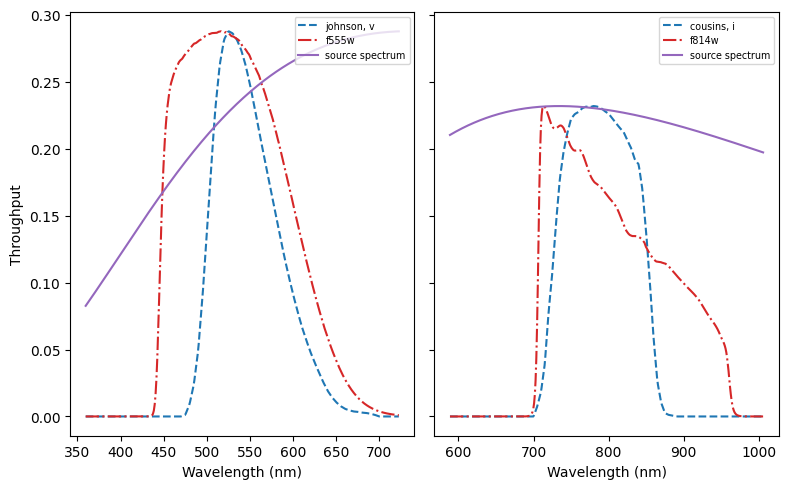

In [14]:
fig, axs = plt.subplots(1, len(filter_pairs), sharey=True, figsize=(
    4*len(filter_pairs), 5))  # Instantiate subplots
axs[0].set_ylabel('Throughput')
for i, pair in enumerate(filter_pairs):

    f1, f2 = pair
    bp1 = stsyn.band(f1)
    bp2 = stsyn.band('wfc3, uvis1,' + f2)

    # Create wavelength array for subplot based on average bandpass wavelength and width
    avgwave = (bp1.avgwave().to(u.nm) + bp2.avgwave().to(u.nm))/2
    width = (bp1.rectwidth().to(u.nm) + bp2.rectwidth().to(u.nm))/2
    left = max((avgwave - 1.5 * width).value, 1)
    right = (avgwave + 1.5 * width).value

    wl = np.arange(left, right) * u.nm

    # Normalize curves to fit on one set of axes
    bp1_norm = bp1(wl) / np.max(bp1(wl)) * np.max(bp2(wl))
    spec_norm = source_spectrum(
        wl) / np.max(source_spectrum(wl)) * np.max(bp2(wl))

    # Plot bandpasses and spectrum on subplot
    axs[i].plot(wl, bp1_norm, ls='--', label=f1, c='tab:blue')
    axs[i].plot(wl, bp2(wl),  ls='-.', label=f2, c='tab:red')
    axs[i].plot(wl, spec_norm, label='source spectrum', c='tab:purple')
    axs[i].set_xlabel('Wavelength (nm)')
    axs[i].legend(fontsize='x-small', loc='upper right')
plt.tight_layout()

<a id="conclusion"></a>
## 8. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Generating synthetic observations using `synphot` and `stsynphot`.
- Finding color terms between WFC3/UVIS filters and non-HST filters.
- Ploting bandpasses to investigate various throughputs.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Aidan Pidgeon, Jennifer Mack; WFC3 Instrument Team

**Updated on:** 2021-09-13

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `synphot`, or `stsynphot` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `synphot`](https://synphot.readthedocs.io/en/latest/)
* [Citing `stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html)

***
[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 